## Accessing ICESat-2 Data
### Data Query and Basic Download Example Notebook
This notebook illustrates the use of icepyx for ICESat-2 data access and download from the NASA NSIDC DAAC (NASA National Snow and Ice Data Center Distributed Active Archive Center).
A complimentary notebook demonstrates in greater detail the subsetting options available when ordering data.

#### Credits
* notebook by: Jessica Scheick
* source material: [NSIDC Data Access Notebook](https://github.com/ICESAT-2HackWeek/ICESat2_hackweek_tutorials/tree/master/03_NSIDCDataAccess_Steiker) by Amy Steiker and Bruce Wallin


### Import packages, including icepyx

In [1]:
import icepyx as ipx
import os
import shutil
%matplotlib inline

### Quick-Start

The entire process of getting ICESat-2 data (from query to download) can ultimately be accomplished in three minimal lines of code:

`region_a = ipx.Query(short_name, spatial_extent, date_range)`

`region_a.earthdata_login(earthdata_uid, email)`

`region_a.download_granules(path)`

where the function inputs are described in more detail below.

**The rest of this notebook explains the required inputs used above, optional inputs not available in the minimal example, and the other data search and visualization tools built in to icepyx that make it easier for the user to find, explore, and download ICESat-2 data programmatically from NSIDC.** The detailed steps outlined and the methods showcased below are meant to give the user more control over the data they find and download (including options to order/download only the relevant portions of a data granule), some of which are called using default values behind the scenes if the user simply skips to the `download_granules` step.

### Create an ICESat-2 data object with the desired search parameters

There are three required inputs:
- `short_name` = the dataset of interest, known as its "short name".
See https://nsidc.org/data/icesat-2/data-sets for a list of the available datasets.
- `spatial extent` = a region of interest to search within. This can be entered as a bounding box, polygon vertex coordinate pairs, or a polygon geospatial file (currently shp, kml, and gpkg are supported).
    - bounding box: Given in decimal degrees for the lower left longitude, lower left latitude, upper right longitude, and upper right latitude
    - polygon vertices: Given as longitude, latitude coordinate pairs of decimal degrees with the last entry a repeat of the first.
    - polygon file: A string containing the full file path and name.
- `date_range` = the date range for which you would like to search for results. Must be formatted as a set of 'YYYY-MM-DD' strings.

Below are examples of each type of spatial extent input. Please choose and run only one of the next three cells.

In [2]:
#bounding box
short_name = 'ATL06'
spatial_extent = [-55, 68, -48, 71]
date_range = ['2019-02-20','2019-02-28']

In [ ]:
#polygon vertices (here equivalent to the bounding box, above)
short_name = 'ATL06'
spatial_extent = [(-55, 68), (-55, 71), (-48, 71), (-48, 68), (-55, 68)]
date_range = ['2019-02-20','2019-02-28']

In [ ]:
#polygon geospatial file (metadata match but no subset match)
# short_name = 'ATL06'
# spatial_extent = './supporting_files/data-access_PineIsland/glims_polygons.kml'
# date_range = ['2019-02-22','2019-02-28']

#polygon geospatial file (subset and metadata match)
short_name = 'ATL06'
spatial_extent = './supporting_files/data-access_PineIsland/glims_polygons.shp'
date_range = ['2019-10-01','2019-10-05']

Create the data object using our inputs

In [3]:
region_a = ipx.Query(short_name, spatial_extent, date_range)

Formatted parameters and function calls allow us to see the the properties of the data object we have created.

ATL06
['2019-02-20', '2019-02-28']
00:00:00
23:59:59
003
['02']
['0841', '0849', '0902', '0910']


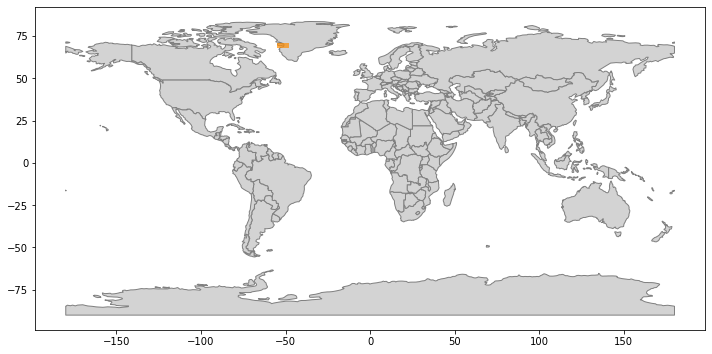

In [5]:
print(region_a.dataset)
print(region_a.dates)
print(region_a.start_time)
print(region_a.end_time)
print(region_a.dataset_version)
print(region_a.cycles)
print(region_a.tracks)
# print(region_a.spatial_extent)
region_a.visualize_spatial_extent()

There are also several optional inputs to allow the user finer control over their search.
- `start_time` = start time to search for data on the start date. If no input is given, this defaults to 00:00:00.
- `end_time` = end time for the end date of the temporal search parameter. If no input is given, this defaults to 23:59:59. Times must be input as 'HH:mm:ss' strings.
- `version` = What version of the dataset to use, input as a numerical string. If no input is given, this value defaults to the most recent version of the dataset specified in `short_name`.

*NOTE* Version 001 is used as an example in the below cell. However, using it will cause 'no results' errors in granule ordering for some search parameters. These issues have been resolved in later versions of the datasets, so it is best to use the most recent version where possible. Thus, you will need to change the version associated with `region_a` and rerun the next cell for the rest of this notebook to run.

In [12]:
region_a = ipx.Query(short_name, spatial_extent, date_range, \
   start_time='03:30:00', end_time='21:30:00', version='003')

print(region_a.dataset)
print(region_a.dates)
print(region_a.start_time)
print(region_a.end_time)
print(region_a.dataset_version)
print(region_a.cycles)
print(region_a.tracks)
# print(region_a.spatial_extent)

/Users/rominapiunno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ATL06
['2019-02-20', '2019-02-28']
03:30:00
21:30:00
003
['02']
['0841', '0849', '0902', '0910']


Finally, there are also two optional inputs to allow the user to search based on orbital parameters. Note that your search will return a no-data error if your cycles or tracks are not withint your spatial extent.
- `cycles` = Which orbital cycle of the dataset to use, input as a numerical string or a list of strings. If no input is given, this value defaults to all available cycles within the search parameters.  An orbital cycle refers to the 91-day repeat period of the ICESat-2 orbit.
- `tracks` = Which [Reference Ground Track (RGT)](https://icesat-2.gsfc.nasa.gov/science/specs) of the dataset to use, input as a numerical string or a list of strings. If no input is given, this value defaults to all available RGTs within the spatial and temporal search parameters.

In [7]:
region_a = ipx.Query(short_name, spatial_extent, date_range, \
   cycles='02', tracks=['0849','0902'])

print(region_a.dataset)
print(region_a.dates)
print(region_a.start_time)
print(region_a.end_time)
print(region_a.dataset_version)
print(region_a.cycles)
print(region_a.tracks)
print(region_a.orbit_number)
# print(region_a.spatial_extent)

/Users/rominapiunno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ATL06
['2019-02-20', '2019-02-28']
00:00:00
23:59:59
003
['02']
['0849', '0902']
2437,2490


Alternatively, you can also just create the data object without creating named variables first:

In [ ]:
# region_a = ipx.Query('ATL06',[-55, 68, -48, 71],['2019-02-01','2019-02-28'], 
#                            start_time='00:00:00', end_time='23:59:59', version='002')

### Built in methods allow us to get more information about our dataset
In addition to viewing the stored object information shown above (e.g. dataset, start and end date and time, version, etc.), we can also request summary information about the dataset itself or confirm that we have manually specified the latest version.

In [13]:
region_a.dataset_summary_info()
print(region_a.latest_version())

dataset_id :  ATLAS/ICESat-2 L3A Land Ice Height V003
short_name :  ATL06
version_id :  003
time_start :  2018-10-14T00:00:00.000Z
coordinate_system :  CARTESIAN
summary :  This data set (ATL06) provides geolocated, land-ice surface heights (above the WGS 84 ellipsoid, ITRF2014 reference frame), plus ancillary parameters that can be used to interpret and assess the quality of the height estimates. The data were acquired by the Advanced Topographic Laser Altimeter System (ATLAS) instrument on board the Ice, Cloud and land Elevation Satellite-2 (ICESat-2) observatory.
orbit_parameters :  {'swath_width': '36.0', 'period': '96.8', 'inclination_angle': '92.0', 'number_of_orbits': '0.071428571', 'start_circular_latitude': '0.0'}
003


/Users/rominapiunno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


If the summary does not provide all of the information you are looking for, or you would like to see information for previous versions of the dataset, all available metadata for the collection dataset is available in a readable format.

In [14]:
region_a.dataset_all_info()

{'feed': {'entry': [{'archive_center': 'NASA NSIDC DAAC',
                     'associations': {'services': ['S1568899363-NSIDC_ECS',
                                                   'S1613669681-NSIDC_ECS',
                                                   'S1613689509-NSIDC_ECS']},
                     'boxes': ['-90 -180 90 180'],
                     'browse_flag': False,
                     'coordinate_system': 'CARTESIAN',
                     'data_center': 'NSIDC_ECS',
                     'dataset_id': 'ATLAS/ICESat-2 L3A Land Ice Height V002',
                     'has_formats': True,
                     'has_spatial_subsetting': True,
                     'has_temporal_subsetting': True,
                     'has_transforms': False,
                     'has_variables': True,
                     'id': 'C1631076765-NSIDC_ECS',
                     'links': [{'href': 'https://n5eil01u.ecs.nsidc.org/ATLAS/ATL06.002/',
                                'hreflang': 'en-US',
 

/Users/rominapiunno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Querying a dataset
In order to search the dataset collection for available data granules, we need to build our search parameters. This is done automatically behind the scenes when you run `region_a.avail_granules()`, but you can also build and view them by calling `region_a.CMRparams`. These are formatted as a dictionary of key:value pairs according to the CMR documentation.

In [15]:
#build and view the parameters that will be submitted in our query
region_a.CMRparams

/Users/rominapiunno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'short_name': 'ATL06',
 'version': '003',
 'temporal': '2019-02-20T03:30:00Z,2019-02-28T21:30:00Z',
 'bounding_box': '-55.0,68.0,-48.0,71.0'}

Now that our parameter dictionary is constructed, we can search the CMR database for the available granules. Granules returned by the CMR metadata search are automatically stored within the data object. The search completed at this level relies completely on the granules' metadata. As a result, some (and in rare cases all) of the granules returned may not actually contain data in your specified region, particularly if the region is small or located near the boundaries of a given granule. If this is the case, the subsetter will not return any data when you actually place the order.

In [16]:
#search for available granules and provide basic summary info about them
region_a.avail_granules()

/Users/rominapiunno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'Number of available granules': 4,
 'Average size of granules (MB)': 44.784337758999996,
 'Total size of all granules (MB)': 179.13735103599998}

In [17]:
#get a list of granule IDs for the available granules
region_a.avail_granules(ids=True)

/Users/rominapiunno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['ATL06_20190221121851_08410203_003_01.h5',
  'ATL06_20190222010344_08490205_003_01.h5',
  'ATL06_20190225121032_09020203_003_01.h5',
  'ATL06_20190226005526_09100205_003_01.h5']]

In [18]:
#print detailed information about the returned search results
region_a.granules.avail

/Users/rominapiunno/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[{'producer_granule_id': 'ATL06_20190221121851_08410203_003_01.h5',
  'time_start': '2019-02-21T12:19:05.190Z',
  'orbit': {'ascending_crossing': '-40.35812957405553',
   'start_lat': '59.5',
   'start_direction': 'A',
   'end_lat': '80',
   'end_direction': 'A'},
  'updated': '2020-05-04T15:43:02.942Z',
  'orbit_calculated_spatial_domains': [{'equator_crossing_date_time': '2019-02-21T12:03:18.922Z',
    'equator_crossing_longitude': '-40.35812957405553',
    'orbit_number': '2429'}],
  'dataset_id': 'ATLAS/ICESat-2 L3A Land Ice Height V003',
  'data_center': 'NSIDC_ECS',
  'title': 'SC:ATL06.003:177534295',
  'coordinate_system': 'ORBIT',
  'time_end': '2019-02-21T12:24:16.043Z',
  'id': 'G1723268629-NSIDC_ECS',
  'original_format': 'ISO-SMAP',
  'granule_size': '50.3300800323',
  'browse_flag': True,
  'polygons': [['58.62975669572381 -47.899339089543176 77.11313865341255 -55.06953885155483 77.78463055907766 -55.65948204030133 77.83817676951094 -54.146243325401755 77.16392707969413 -

### Downloading the found granules
In order to download any data from NSIDC, we must first authenticate ourselves using a valid Earthdata login. This will create a valid token to interface with the DAAC as well as start an active logged-in session to enable data download. Once you have successfully logged in for a given query instance, the token and session will be passed behind the scenes as needed for you to order and download data. Passwords are entered but not shown or stored in plain text by the system.

In [ ]:
earthdata_uid = 'icepyx_devteam'
email = 'icepyx.dev@gmail.com'
region_a.earthdata_login(earthdata_uid, email)

Once we have generated our session, we must build the required configuration parameters needed to actually download data. These will tell the system how we want to download the data. As with the CMR search parameters, these will be built automatically when you run `region_a.order_granules()`, but you can also create and view them with `region_a.reqparams`. The default parameters, given below, should work for most users.
- `page_size` = 10. This is the number of granules we will request per order.
- `page_num` = 1. Determine the number of pages based on page size and the number of granules available. If no page_num is specified, this calculation is done automatically to set page_num, which then provides the number of individual orders we will request given the number of granules.
- `request_mode` = 'async'
- `agent` = 'NO'
- `include_meta` = 'Y'

#### More details about the configuration parameters
`request_mode` is "synchronous" by default, meaning that the request relies on a direct, continous connection between you and the API endpoint. Outputs are directly downloaded, or "streamed", to your working directory. For this tutorial, we will set the request mode to asynchronous, which will allow concurrent requests to be queued and processed without the need for a continuous connection.

**Use the streaming `request_mode` with caution: While it can be beneficial to stream outputs directly to your local directory, note that timeout errors can result depending on the size of the request, and your request will not be queued in the system if NSIDC is experiencing high request volume. For best performance, NSIDC recommends setting `page_size=1` to download individual outputs, which will eliminate extra time needed to zip outputs and will ensure faster processing times per request.**

Recall that we queried the total number and volume of granules prior to applying customization services. `page_size` and `page_num` can be used to adjust the number of granules per request up to a limit of 2000 granules for asynchronous, and 100 granules for synchronous (streaming). For now, let's select 9 granules to be processed in each zipped request. For ATL06, the granule size can exceed 100 MB so we want to choose a granule count that provides us with a reasonable zipped download size. 

In [ ]:
print(region_a.reqparams)
# region_a.reqparams['page_size'] = 9
# print(region_a.reqparams)

#### Additional Parameters: Subsetting

In addition to the required parameters (CMRparams and reqparams) that are submitted with our order, for ICESat-2 datasets we can also submit subsetting parameters to NSIDC. This utilizes the NSIDC's built in subsetter to extract only the data you are interested (spatially, temporally, variables of interest, etc.). The advantages of using the NSIDC's subsetter include:
* easily reproducible downloads, particularly when coupled with and icepyx data object
* smaller file size, meaning faster downloads, less storage required, and no need to subset the data on your own
* still easy to go back and order more data/variables with the same or similar search parameters
* no extraneous data means you can move directly to analysis and easily navigate your dataset

Certain subset parameters are specified by default unless `subset=False` is included as an input to `order_granules()`. A separate, companion notebook tutorial covers subsetting in more detail, including how to get a list of subsetting options, how to build your list of subsetting parameters, and how to generate a list of desired variables (most datasets have more than 200 variable fields!), including using pre-built default lists (these lists are still in progress and we welcome contributions!).

As for the CMR and required parameters, default subset parameters can be built and viewed using `subsetparams`. Where an input spatial file is used, rather than a bounding box or manually entered polygon, the spatial file will be used for subsetting (unless subset is set to False) but not show up in the `subsetparams` dictionary.

In [ ]:
region_a.subsetparams()

In [ ]:
region_a._geom_filepath

#### Place the order
Then, we can send the order to NSIDC using the order_granules function. Information about the granules ordered and their status will be printed automatically as well as emailed to the address provided. Additional information on the order, including request URLs, can be viewed by setting the optional keyword input 'verbose' to True.

In [ ]:
region_a.order_granules()
# region_a.order_granules(verbose=True)

In [ ]:
#view a short list of order IDs
region_a.granules.orderIDs

#### Download the order
Finally, we can download our order to a specified directory (which needs to have a full path but doesn't have to point to an existing directory) and the download status will be printed as the program runs. Additional information is again available by using the optional boolean keyword `verbose`.

In [ ]:
path = './download'
region_a.download_granules(path)